Before fixing:
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

After fixing filenames:
                                     id             breed
0  000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
2  001cdf01b096e06d78e9e5112d419397.jpg          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever
Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.

✅ Found 8178 training and 2044 validation images.
Number of breeds: 120
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.0588 - loss: 4.5851
E

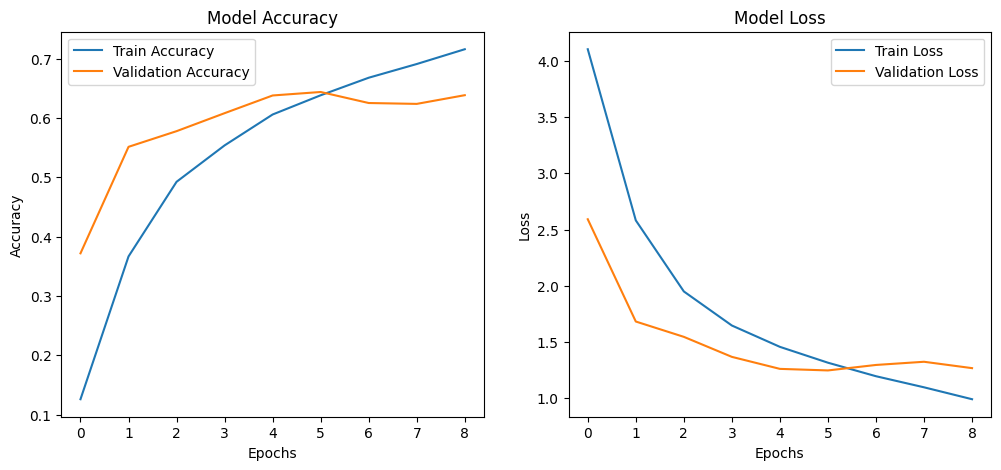

✅ Loaded best saved model for inference.


In [5]:
# 🚀 Dog Breed Classification (Final Version with Checkpointing & EarlyStopping)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# ---------------------------
# 📁 Dataset Paths
# ---------------------------
base_dir = r"C:\Users\HP\Downloads\datasets_dog_breed_classification"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
labels_path = os.path.join(base_dir, "labels.csv")

# ---------------------------
# 🧩 Load Labels
# ---------------------------
df = pd.read_csv(labels_path)
print("Before fixing:")
print(df.head())

df['id'] = df['id'].apply(lambda x: x + ".jpg")

print("\nAfter fixing filenames:")
print(df.head())

# ---------------------------
# 🧠 Data Preprocessing & Augmentation
# ---------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_dir,
    x_col='id',
    y_col='breed',
    target_size=(224, 224),
    batch_size=32,
    subset='training',
    class_mode='categorical'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_dir,
    x_col='id',
    y_col='breed',
    target_size=(224, 224),
    batch_size=32,
    subset='validation',
    class_mode='categorical'
)

print(f"\n✅ Found {train_generator.samples} training and {val_generator.samples} validation images.")
num_classes = len(train_generator.class_indices)
print(f"Number of breeds: {num_classes}")

# ---------------------------
# ⚙️ Base Model (MobileNetV2)
# ---------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = True  # Enable fine-tuning

# Unfreeze last 30 layers for task-specific tuning
for layer in base_model.layers[:-30]:
    layer.trainable = False

# ---------------------------
# 🧩 Model Architecture
# ---------------------------
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# ---------------------------
# 🧮 Compile Model
# ---------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ---------------------------
# 🛑 Callbacks (EarlyStopping & Checkpoint)
# ---------------------------
checkpoint_path = "best_dog_breed_model.keras"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path,
                    monitor='val_accuracy',
                    save_best_only=True,
                    verbose=1)
]

# ---------------------------
# 🏋️ Train Model
# ---------------------------
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

# ---------------------------
# 🧪 Evaluate Model
# ---------------------------
val_loss, val_acc = model.evaluate(val_generator)
print(f"\n✅ Best Validation Accuracy: {val_acc*100:.2f}%")

# ---------------------------
# 📊 Plot Accuracy & Loss
# ---------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# ---------------------------
# 💾 Load Best Model (Optional)
# ---------------------------
best_model = tf.keras.models.load_model(checkpoint_path)
print("✅ Loaded best saved model for inference.")


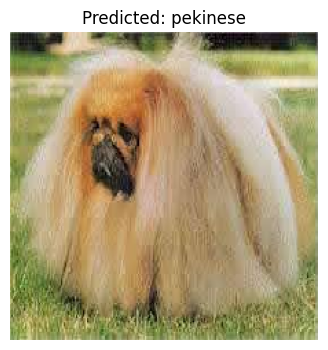

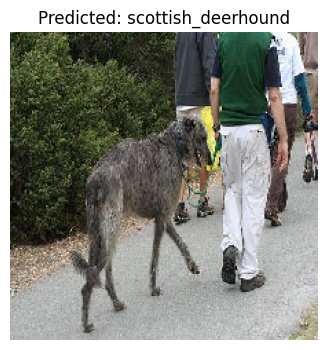

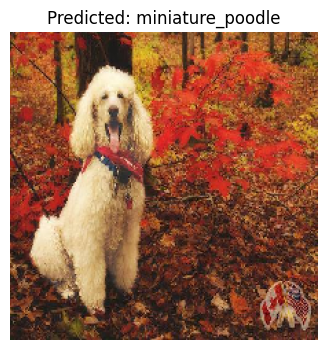

In [6]:
import random
labels = list(train_generator.class_indices.keys())

# Get test image file names
test_images = [img for img in os.listdir(test_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Predict on 3 random test images
for i in range(3):
    random_img = random.choice(test_images)
    img_path = os.path.join(test_dir, random_img)

    # Load and preprocess image
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array, verbose=0)
    predicted_label = labels[np.argmax(prediction)]

    # Display result
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}")
    plt.show()